This is an supervised classification example taken from the KDD 2009 cup.  A copy of the data and details can be found here: [https://github.com/WinVector/PDSwR2/tree/master/KDD2009](https://github.com/WinVector/PDSwR2/tree/master/KDD2009).  The problem was to predict account cancellation ("churn") from very messy data (column names not given, numeric and categorical variables, many missing values, some categorical variables with a large number of possible levels).  In this example we show how to quickly use `vtreat` to prepare the data for modeling.  `vtreat` takes in `Pandas` `DataFrame`s and returns both a treatment plan and a clean `Pandas` `DataFrame` ready for modeling.

Load our packages/modules.

In [1]:
import pandas
import xgboost
import vtreat
import vtreat.cross_plan
import numpy.random
import wvpy.util
import scipy.sparse

Read in explanitory variables.

In [2]:
# data from https://github.com/WinVector/PDSwR2/tree/master/KDD2009
dir = "../../../PracticalDataScienceWithR2nd/PDSwR2/KDD2009/"
d = pandas.read_csv(dir + 'orange_small_train.data.gz', sep='\t', header=0)
vars = [c for c in d.columns]
d.shape

(50000, 230)

Read in dependent variable we are trying to predict.

In [3]:
churn = pandas.read_csv(dir + 'orange_small_train_churn.labels.txt', header=None)
churn.columns = ["churn"]
churn.shape

(50000, 1)

In [4]:
churn["churn"].value_counts()

-1    46328
 1     3672
Name: churn, dtype: int64

Arrange test/train split.

In [5]:
numpy.random.seed(855885)
n = d.shape[0]
# https://github.com/WinVector/pyvtreat/blob/master/Examples/CustomizedCrossPlan/CustomizedCrossPlan.md
split1 = vtreat.cross_plan.KWayCrossPlanYStratified().split_plan(n_rows=n, k_folds=10, y=churn.iloc[:, 0])
train_idx = set(split1[0]['train'])
is_train = [i in train_idx for i in range(n)]
is_test = numpy.logical_not(is_train)

(The reported performance runs of this example were sensitive to the prevalance of the churn variable in the test set, we are cutting down on this source of evaluation variarance by using the stratified split.)

In [6]:
d_train = d.loc[is_train, :].copy()
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"]==1)
d_test = d.loc[is_test, :].copy()
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"]==1)

Take a look at the dependent variables.  They are a mess, many missing values.  Categorical variables that can not be directly used without some re-encoding.

In [7]:
d_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [8]:
d_train.shape

(45000, 230)

Try building a model directly off this data (this will fail).

In [9]:
fitter = xgboost.XGBClassifier(n_estimators=10, max_depth=3, objective='binary:logistic')
try:
    fitter.fit(d_train, churn_train)
except Exception as ex:
    print(ex)

DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Var191, Var192, Var193, Var194, Var195, Var196, Var197, Var198, Var199, Var200, Var201, Var202, Var203, Var204, Var205, Var206, Var207, Var208, Var210, Var211, Var212, Var213, Var214, Var215, Var216, Var217, Var218, Var219, Var220, Var221, Var222, Var223, Var224, Var225, Var226, Var227, Var228, Var229


Let's quickly prepare a data frame with none of these issues.

We start by building our treatment plan, this has the `sklearn.pipeline.Pipeline` interfaces.

In [10]:
plan = vtreat.BinomialOutcomeTreatment(outcome_target=True)

Use `.fit_transform()` to get a special copy of the treated training data that has cross-validated mitigations againsst nested model bias. We call this a "cross frame." `.fit_transform()` is deliberately a different `DataFrame` than what would be returned by `.fit().transform()` (the `.fit().transform()` would damage the modeling effort due nested model bias, the `.fit_transform()` "cross frame" uses cross-validation techniques similar to "stacking" to mitigate these issues).

In [11]:
cross_frame = plan.fit_transform(d_train, churn_train)

Take a look at the new data.  This frame is guaranteed to be all numeric with no missing values, with the rows in the same order as the training data.

In [12]:
cross_frame.head()

,Var2_is_bad,Var3_is_bad,Var4_is_bad,Var5_is_bad,Var6_is_bad,Var7_is_bad,Var10_is_bad,Var11_is_bad,Var13_is_bad,Var14_is_bad,...,Var227_lev_RAYp,Var227_lev_ZI9m,Var228_logit_code,Var228_prevalence_code,Var228_lev_F2FyR07IdsN7I,Var229_logit_code,Var229_prevalence_code,Var229_lev__NA_,Var229_lev_am7c,Var229_lev_mj86
0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.151682,0.653733,1.0,0.172744,0.567422,1.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.146119,0.653733,1.0,0.175707,0.567422,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,-0.629820,0.053956,0.0,-0.263504,0.234400,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.145871,0.653733,1.0,0.159486,0.567422,1.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.147432,0.653733,1.0,-0.286852,0.196600,0.0,0.0,1.0


In [13]:
cross_frame.shape

(45000, 216)

Pick a recommended subset of the new derived variables.

In [14]:
plan.score_frame_.head()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,Var1_is_bad,Var1,missing_indicator,False,True,0.003283,0.486212,193.0,0.001036,False
1,Var2_is_bad,Var2,missing_indicator,False,True,0.019270,0.000044,193.0,0.001036,True
2,Var3_is_bad,Var3,missing_indicator,False,True,0.019238,0.000045,193.0,0.001036,True
3,Var4_is_bad,Var4,missing_indicator,False,True,0.018744,0.000070,193.0,0.001036,True
4,Var5_is_bad,Var5,missing_indicator,False,True,0.017575,0.000193,193.0,0.001036,True


In [15]:
model_vars = numpy.asarray(plan.score_frame_["variable"][plan.score_frame_["recommended"]])
len(model_vars)

216

Fit the model

In [16]:
cross_frame.dtypes

Var2_is_bad                            float64
Var3_is_bad                            float64
Var4_is_bad                            float64
Var5_is_bad                            float64
Var6_is_bad                            float64
                                  ...         
Var229_logit_code                      float64
Var229_prevalence_code                 float64
Var229_lev__NA_           Sparse[float64, 0.0]
Var229_lev_am7c           Sparse[float64, 0.0]
Var229_lev_mj86           Sparse[float64, 0.0]
Length: 216, dtype: object

In [17]:
# fails due to sparse columns
# can also work around this by setting the vtreat parameter 'sparse_indicators' to False
try:
    cross_sparse = xgboost.DMatrix(data=cross_frame.loc[:, model_vars], label=churn_train)
except Exception as ex:
    print(ex)

DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Var193_lev_RO12, Var193_lev_2Knk1KF, Var194_lev__NA_, Var194_lev_SEuy, Var195_lev_taul, Var200_lev__NA_, Var201_lev__NA_, Var201_lev_smXZ, Var205_lev_VpdQ, Var206_lev_IYzP, Var206_lev_zm5i, Var206_lev__NA_, Var207_lev_me75fM6ugJ, Var207_lev_7M47J5GA0pTYIFxg5uy, Var210_lev_uKAI, Var211_lev_L84s, Var211_lev_Mtgm, Var212_lev_NhsEn4L, Var212_lev_XfqtO3UdzaXh_, Var213_lev__NA_, Var214_lev__NA_, Var218_lev_cJvF, Var218_lev_UYBR, Var221_lev_oslk, Var221_lev_zCkv, Var225_lev__NA_, Var225_lev_ELof, Var225_lev_kG3k, Var226_lev_FSa2, Var227_lev_RAYp, Var227_lev_ZI9m, Var228_lev_F2FyR07IdsN7I, Var229_lev__NA_, Var229_lev_am7c, Var229_lev_mj86


In [18]:
# also fails
try:
    cross_sparse = scipy.sparse.csc_matrix(cross_frame[model_vars])
except Exception as ex:
    print(ex)

no supported conversion for types: (dtype('O'),)


In [19]:
# works
cross_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(cross_frame[[vi]]) for vi in model_vars])

In [20]:
# https://xgboost.readthedocs.io/en/latest/python/python_intro.html
fd = xgboost.DMatrix(
    data=cross_sparse, 
    label=churn_train)

In [21]:
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cv = xgboost.cv(x_parameters, fd, num_boost_round=100, verbose_eval=False)

In [22]:
cv.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.073378,0.000322,0.073733,0.000669
1,0.073411,0.000257,0.073511,0.000529
2,0.073433,0.000268,0.073578,0.000514
3,0.073444,0.000283,0.073533,0.000525
4,0.073444,0.000283,0.073533,0.000525


In [23]:
best = cv.loc[cv["test-error-mean"]<= min(cv["test-error-mean"] + 1.0e-9), :]
best



,train-error-mean,train-error-std,test-error-mean,test-error-std
21,0.072756,0.000177,0.073267,0.000327


In [24]:
ntree = best.index.values[0]
ntree

21

In [25]:
fitter = xgboost.XGBClassifier(n_estimators=ntree, max_depth=3, objective='binary:logistic')
fitter

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=21, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
model = fitter.fit(cross_sparse, churn_train)

Apply the data transform to our held-out data.

In [27]:
test_processed = plan.transform(d_test)

Plot the quality of the model on training data (a biased measure of performance).

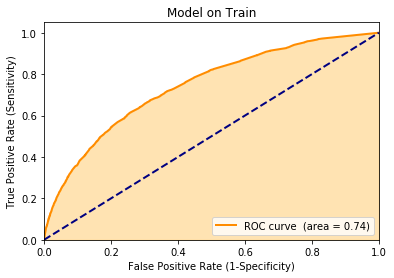

0.7424056263753072

In [28]:
pf_train = pandas.DataFrame({"churn":churn_train})
pf_train["pred"] = model.predict_proba(cross_sparse)[:, 1]
wvpy.util.plot_roc(pf_train["pred"], pf_train["churn"], title="Model on Train")

Plot the quality of the model score on the held-out data.  This AUC is not great, but in the ballpark of the original contest winners.

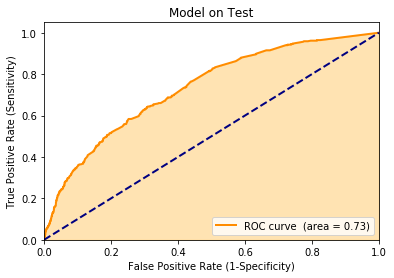

0.7328696191869485

In [29]:
test_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(test_processed[[vi]]) for vi in model_vars])
pf = pandas.DataFrame({"churn":churn_test})
pf["pred"] = model.predict_proba(test_sparse)[:, 1]
wvpy.util.plot_roc(pf["pred"], pf["churn"], title="Model on Test")

Notice we dealt with many problem columns at once, and in a statistically sound manner. More on the `vtreat` package for Python can be found here: [https://github.com/WinVector/pyvtreat](https://github.com/WinVector/pyvtreat).  Details on the `R` version can be found here: [https://github.com/WinVector/vtreat](https://github.com/WinVector/vtreat).

We can compare this to the [R solution (link)](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).

We can compare the above cross-frame solution to a naive "design transform and model on the same data set" solution as we show below.  Note we turn off `filter_to_recommended` as this is computed using cross-frame techniques (and hence is a non-naive estimate).

In [30]:
plan_naive = vtreat.BinomialOutcomeTreatment(
    outcome_target=True,              
    params=vtreat.vtreat_parameters({'filter_to_recommended':False}))
plan_naive.fit(d_train, churn_train)
naive_frame = plan_naive.transform(d_train)

In [31]:
naive_sparse = scipy.sparse.hstack([scipy.sparse.csc_matrix(naive_frame[[vi]]) for vi in model_vars])

In [32]:
fd_naive = xgboost.DMatrix(data=naive_sparse, label=churn_train)
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cvn = xgboost.cv(x_parameters, fd_naive, num_boost_round=100, verbose_eval=False)

In [33]:
bestn = cvn.loc[cvn["test-error-mean"]<= min(cvn["test-error-mean"] + 1.0e-9), :]
bestn

,train-error-mean,train-error-std,test-error-mean,test-error-std
94,0.0485,0.000438,0.058622,0.000545


In [34]:
ntreen = bestn.index.values[0]
ntreen

94

In [35]:
fittern = xgboost.XGBClassifier(n_estimators=ntreen, max_depth=3, objective='binary:logistic')
fittern

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=94, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [36]:
modeln = fittern.fit(naive_sparse, churn_train)

In [37]:
test_processedn = plan_naive.transform(d_test)
test_processedn = scipy.sparse.hstack([scipy.sparse.csc_matrix(test_processedn[[vi]]) for vi in model_vars])

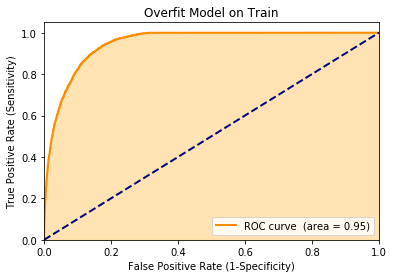

0.9492686875296688

In [38]:
pfn_train = pandas.DataFrame({"churn":churn_train})
pfn_train["pred_naive"] = modeln.predict_proba(naive_sparse)[:, 1]
wvpy.util.plot_roc(pfn_train["pred_naive"], pfn_train["churn"], title="Overfit Model on Train")

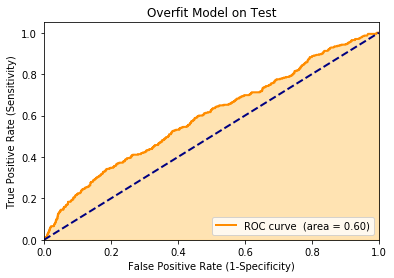

0.5960012412998182

In [39]:
pfn = pandas.DataFrame({"churn":churn_test})
pfn["pred_naive"] = modeln.predict_proba(test_processedn)[:, 1]
wvpy.util.plot_roc(pfn["pred_naive"], pfn["churn"], title="Overfit Model on Test")

Note the naive test performance is worse, despite its far better training performance.  This is over-fit due to the nested model bias of using the same data to build the treatment plan and model without any cross-frame mitigations.